# Numerical Simulation of Stochastic Storm Transposition (SST)

In this notebook we will use synthetic data and a 1-dimensional watershed model to investigate the impact of various assumptions in SST.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from scipy.stats import  expon, uniform, rv_continuous, ks_2samp, genpareto, zscore, norm
from typing import Callable

Helper Functions

In [3]:
def get_ams(time: np.ndarray, value: np.ndarray) -> np.ndarray:
    """Extract annual maximums from timeseries."""
    year = np.floor(time / 365)
    ams = []
    for y in np.unique(year):
        ams.append(value[year == y].max())
    return np.array(ams)

In [4]:
def sst(storm_catalog: list, spatial_sampler: rv_continuous, watershed_function: Callable) -> list:
    """Randomly transpose storms across a domain and evaluate basin discharge."""
    new_locs = spatial_sampler.rvs(size=len(storm_catalog))
    qs = storm_catalog * watershed_function(new_locs)
    return qs

### Example 1: Simple SST

Define a watershed function (stand-in for running HMS).  This converts precipitation to discharge.

Text(0, 0.5, 'Unit Discharge (cfs/in)')

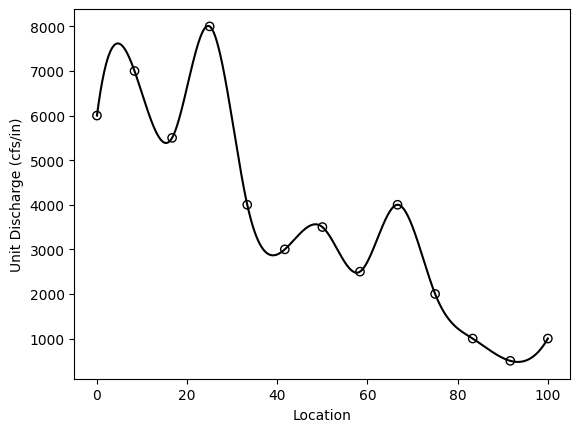

In [5]:
y = [6000, 7000, 5500, 8000, 4000, 3000, 3500, 2500, 4000, 2000, 1000, 500, 1000]  # Unit discharge
n = len(y)
x = np.linspace(0, 100, n)  # watershed spatial component
tck = splrep(x, y)
watershed = lambda x: splev(x, tck, ext=1)

fig, ax = plt.subplots()
ax.scatter(x, y, ec='k', fc='none')
xfit = np.linspace(0, 100, 1000)
yfit = watershed(xfit)
ax.plot(xfit, yfit, c='k')
ax.set_xlabel("Location")
ax.set_ylabel("Unit Discharge (cfs/in)")

Define a storm generator for the homogeneous region.

These distributions represent the long-term behavior of storms in the area if we had infinite record length and the behavior was parametric.

In [6]:
storm_rate = 240  # 24 storms per year
storm_rate /= 365 # storms per day
arrival_dist = expon(scale = 1 / storm_rate)
precipitation_dist = genpareto(c=0.5, loc=1, scale=10)
location_dist = uniform(0, 1000)

Note that the location distribution ranges 0-1000 whereas the watershed function is only defined on 0-100. Under this configuration, the homogeneous region is larger than the watershed (typical).

Approximate the long term flood series.

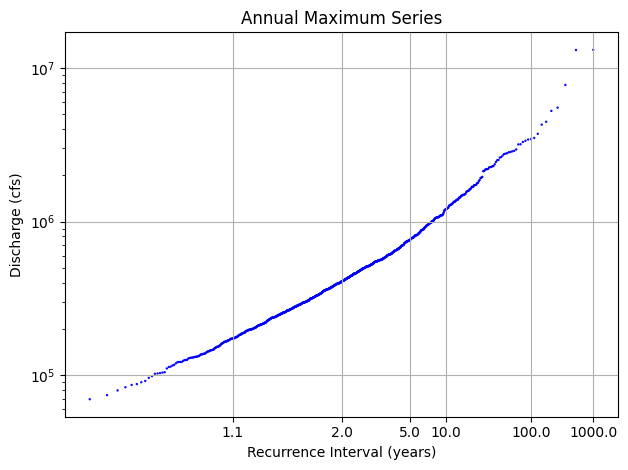

In [7]:
record_length = 1000  # years

# Get event times
interevents = arrival_dist.rvs(int(record_length * storm_rate * 365 * 1.2))
arrivals = interevents.cumsum()
arrivals = arrivals[arrivals < (record_length * 365)]
n = len(arrivals)

# Get event characteristics
p = precipitation_dist.rvs(size=n)
l = location_dist.rvs(size=n)

# Get long-term flood series.
qs = p * watershed(l)
ams = get_ams(arrivals, qs)

# Plot summary
q_sort = np.sort(ams)[::-1]
aep = np.array([(i + 1) / (len(ams) + 1) for i in range(len(ams))])
z = norm.ppf(1 - aep)

fig, ax = plt.subplots()

ax.scatter(z, q_sort, ec='b', fc='none', s=0.5)

ris = np.array([1.1, 2, 5, 10, 100, 1000])
aep = 1 / ris
z_ticks = norm.ppf(1 - aep)
ax.set_xticks(z_ticks)
ax.set_xticklabels(ris)
ax.set_xlabel("Recurrence Interval (years)")
ax.set_yscale("log")
ax.set_ylabel("Discharge (cfs)")
ax.set_title("Annual Maximum Series")
plt.grid(True)
plt.tight_layout()

Create a limited observation series.  Here we only let ourselves see 30 years of data.

In [8]:
observed_record_length = 30  # years
p_obs = p[arrivals < (observed_record_length * 365)]
t_obs = arrivals[arrivals < (observed_record_length * 365)]
lambda_obs = len(t_obs) / observed_record_length  # events per year

Then select a number of largest storms to sample from the period of record. This becomes the storm catalog.

In [9]:
storm_count = 750
storm_catalog = np.sort(np.array(p_obs))[-storm_count:]
lambda_catalog = storm_count / observed_record_length
lambda_catalog /= 365

Then we perform SST.  Choose a record length to simulate and choose a number of epochs to run.

In [10]:
simulated_length = 100  # years
epochs = 100

sst_arrival_dist = expon(scale = 1 / lambda_catalog)
sst_location_dist = uniform(0, 1000)

sst_qs = []

for e in range(epochs):
    # Simulate storm dates
    interevents = sst_arrival_dist.rvs(int(simulated_length * (lambda_catalog) * 365 * 1.2))
    arrivals = interevents.cumsum()
    arrivals = arrivals[arrivals < (simulated_length * 365)]
    n = len(arrivals)
    
    sampled_storms = np.random.choice(storm_catalog, n)
    sampled_qs = sst(sampled_storms, sst_location_dist, watershed)
    sampled_ams = get_ams(arrivals, sampled_qs)
    sst_qs.append(sampled_ams)



Plot the results

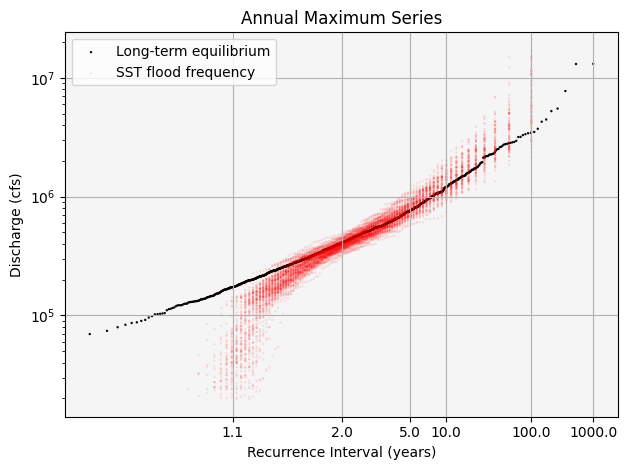

In [11]:
q_sort = np.sort(ams)[::-1]
aep = np.array([(i + 1) / (len(ams) + 1) for i in range(len(ams))])
z = norm.ppf(1 - aep)

fig, ax = plt.subplots()

ax.scatter(z, q_sort, ec='k', fc='none', s=0.5, label="Long-term equilibrium")
add_label = True
for i in sst_qs:
    tmp_q_sort = np.sort(i)[::-1]
    aep = np.array([(i + 1) / (len(tmp_q_sort) + 1) for i in range(len(tmp_q_sort))])
    z = norm.ppf(1 - aep)
    if add_label:
        l = "SST flood frequency"
        add_label = False
    else:
        l = None
    ax.scatter(z, tmp_q_sort, ec='r', fc='none', s=0.5, alpha=0.1, label=l)

ax.legend()
ris = np.array([1.1, 2, 5, 10, 100, 1000])
aep = 1 / ris
z_ticks = norm.ppf(1 - aep)
ax.set_xticks(z_ticks)
ax.set_xticklabels(ris)
ax.set_xlabel("Recurrence Interval (years)")
ax.set_yscale("log")
ax.set_ylabel("Discharge (cfs)")
ax.set_title("Annual Maximum Series")
ax.set_facecolor("whitesmoke")
plt.grid(True)
plt.tight_layout()

Note the bias for frequent events.  We'll touch on that next in #2.